In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
X_train = df_train['Pixels'].str.split(" ", expand = True)
X_train = np.asarray(X_train).astype(int)
X_train = X_train.reshape(-1,48,48)

y_train = np.asarray(df_train['Emotion']).reshape(-1,1).astype(int)

print(f'The shape of X_train is {len(X_train)}.\nThe shape of y_train is {len(y_train)}.')

The shape of X_train is 4178.
The shape of y_train is 4178.


In [4]:
Emotion = {0:'Anger',
           1:'Disgust',
           2:'Fear',
           3:'Happy',
           4:'Sad',
           5:'Surprise',
           6:'Neutral'}

In [16]:
# Display face sample
from random import random


def display_samp(num):
    ax = plt.figure(figsize = (3,3))
    ax = sns.heatmap(X_train[num], cmap = 'gray', cbar = False)
    ax.set(yticklabels = [], xticklabels = [])
    plt.title(Emotion[int(y_train[num])])
    plt.show()

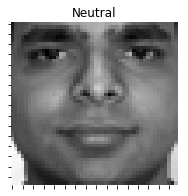

In [19]:
display_samp(np.random.randint(len(X_train)))